## Data loading

In [1]:
# Data format:
#
# n0, n1, ...
# mu0, k00, k01, ..., k0n
# ...
# mun, kn0, kn1, ..., knn

import csv
import numpy as np

#data_file_name = 'data/axioms-toy.csv'
#data_file_name = 'data/data-tettamanzi-little.csv'
data_file_name = 'data/data-tettamanzi-complete.csv'

with open(data_file_name) as data_file:
    data = np.array(list(csv.reader(data_file)))

n = len(data) - 1

print '%d data items' % n

1444 data items


## Extract data names, membership values and Gram matrix

In [2]:
n = 1444

names = np.array(data[0])[1:n+1]
mu = np.array([float(row[0]) for row in data[1:n+1]])
gram = np.array([[float(k.replace('NA', '0')) for k in row[1:n+1]] for row in data[1:n+1]])

assert(len(names.shape) == 1)
assert(len(mu.shape) == 1)
assert(len(gram.shape) == 2)
assert(names.shape[0] == gram.shape[0] == gram.shape[1] == mu.shape[0])

## Compute adjustement in case of ill-conditioned Gram matrix

In [3]:
eigvals = np.linalg.eigvals(gram)
assert(sum([abs(e.imag) for e in eigvals]) < 1e-4)
abs_neg_eigvals = [-l.real for l in eigvals if l < 0]
adjustment = max(abs_neg_eigvals) if abs_neg_eigvals else 0
if adjustment:
    print('non PSD matrix: diagonal adjusment of {0}'.format(adjustment))

non PSD matrix: diagonal adjusment of 292.405301431


## Retrieve hardness index for axioms ##

In [4]:
import json
with open('hardness.json', 'r') as f:
    hardness = json.load(f)

num_hard = sum(hardness)
num_easy = n - num_hard
hardness_count = (num_easy, num_hard)

print 'There are {} easy and {} hard axioms'.format(num_easy, num_hard)

There are 1410 easy and 34 hard axioms


   ## Learning membership for "easy" axioms ##

In [72]:
from possibilearn import split_indices, flatten, possibility_learn
from possibilearn.kernel import PrecomputedKernel
from possibilearn.fuzzifiers import CrispFuzzifier

def square_errors(a, b):
    return map(lambda (a, b): (b-a)**2, zip(a, b))

def performance_mu_summary(axioms, mu, membership):
    perf = square_errors([membership(a) for a in axioms], mu)
    return (np.mean(perf), np.median(perf))

def performance_poss_summary(estimated, actual):
    perf = square_errors(estimated, actual)
    return (np.mean(perf), np.median(perf))

def poss((phi, notphi), membership):
    return membership(phi)-membership(notphi)

k = PrecomputedKernel(gram)

def experiment(fuzzifier):
    axiom_indices = range(n)

    hardness_class = 1
    hard_axiom_indices = [i for i in range(n) if hardness[i]]
    num_hard_axioms = len(hard_axiom_indices)
    mu_hard_axioms = [mu[i] for i in range(n) if hardness[i]]
    
    easy_axiom_indices = [i for i in range(n) if not hardness[i]]
    num_easy_axioms = len(easy_axiom_indices)
    mu_easy_axioms = [mu[i] for i in range(n) if not hardness[i]]
    
    assert(num_easy_axioms + num_hard_axioms == n)

    paired_hard_axioms = [hard_axiom_indices[i:i+2] for i in range(0, num_hard_axioms, 2)]
    paired_hard_labels = [mu_hard_axioms[i:i+2] for i in range(0, num_hard_axioms, 2)]
    
    paired_easy_axioms = [easy_axiom_indices[i:i+2] for i in range(0, num_easy_axioms, 2)]
    paired_easy_labels = [mu_easy_axioms[i:i+2] for i in range(0, num_easy_axioms, 2)]
    
    percentages = (.8, 0, .2)

    (paired_easy_axioms_train,
     _,
     paired_easy_axioms_test,
     paired_easy_mu_train,
     _,
     paired_easy_mu_test) = split_indices(paired_easy_axioms, paired_easy_labels, percentages)
    
    (paired_hard_axioms_train,
     _,
     paired_hard_axioms_test,
     paired_hard_mu_train,
     _,
     paired_hard_mu_test) = split_indices(paired_hard_axioms, paired_hard_labels, percentages)

    paired_axioms_test = paired_easy_axioms_test + paired_hard_axioms_test
    paired_mu_test = paired_easy_mu_test + paired_hard_mu_test
    
    easy_axioms_train = flatten(paired_easy_axioms_train)
    easy_axioms_test = flatten(paired_easy_axioms_test)
    easy_mu_train = flatten(paired_easy_mu_train)
    easy_mu_test = flatten(paired_easy_mu_test)
    
    hard_axioms_train = flatten(paired_hard_axioms_train)
    hard_axioms_test = flatten(paired_hard_axioms_test)
    hard_mu_train = flatten(paired_hard_mu_train)
    hard_mu_test = flatten(paired_hard_mu_test)

    axioms_train = easy_axioms_train + hard_axioms_train
    axioms_test = easy_axioms_test + hard_axioms_test
    mu_train = easy_mu_train + hard_mu_train
    mu_test = easy_mu_test + hard_mu_test

    def g(m):
        return np.random.choice(axiom_indices, m if m <= len(axiom_indices) else len(axiom_indices))
    
    result = possibility_learn(axioms_train, mu_train, c=0.1, k=k, sample_generator=g,
                           adjustment=adjustment, fuzzifier=fuzzifier)

    estimated_membership = result[0]
    train_error = result[1]

    avg_mu_error, median_mu_error = performance_mu_summary(axioms_test, mu_test, estimated_membership)
    avg_mu_error_easy, median_mu_error_easy = performance_mu_summary(easy_axioms_test, easy_mu_test, estimated_membership)
    avg_mu_error_hard, median_mu_error_hard = performance_mu_summary(hard_axioms_test, hard_mu_test, estimated_membership)

    estimated_poss = map(lambda p: poss(p, estimated_membership), paired_axioms_test)
    actual_poss = map(lambda (muphi, munotphi): muphi-munotphi, paired_mu_test)
    avg_poss_error, median_poss_error = performance_poss_summary(estimated_poss, actual_poss)

    estimated_easy_poss = map(lambda p: poss(p, estimated_membership), paired_easy_axioms_test)
    actual_easy_poss = map(lambda (muphi, munotphi): muphi-munotphi, paired_easy_mu_test)
    avg_poss_error_easy, median_poss_error_easy = performance_poss_summary(estimated_easy_poss, actual_easy_poss)

    estimated_hard_poss = map(lambda p: poss(p, estimated_membership), paired_hard_axioms_test)
    actual_hard_poss = map(lambda (muphi, munotphi): muphi-munotphi, paired_hard_mu_test)
    avg_poss_error_hard, median_poss_error_hard = performance_poss_summary(estimated_hard_poss, actual_hard_poss)

    perc_detected_easy = float(len([p for p in estimated_easy_poss if np.abs(p)<0.7]))/len(estimated_easy_poss)
    perc_detected_hard = float(len([p for p in estimated_hard_poss if np.abs(p)<0.7]))/len(estimated_hard_poss)

    return (train_error,
           avg_mu_error, median_mu_error,
           avg_mu_error_easy, median_mu_error_easy,
           avg_mu_error_hard, median_mu_error_hard,
           avg_poss_error, median_poss_error,
           avg_poss_error_easy, median_poss_error_easy,
           avg_poss_error_hard, median_poss_error_hard,
           perc_detected_easy, perc_detected_hard)

In [62]:
results = [experiment(CrispFuzzifier()) for _ in range(10)]

In [63]:
import pandas as pd

rdf = pd.DataFrame(results,
                   columns=('$\mu$ train err', '$\mu$ avg test err', '$\mu$ median err',
                            '$\mu$ avg test err (easy)', '$\mu$ median err (easy)',
                            '$\mu$ avg test err (hard)', '$\mu$ median err (hard)',
                            '$\pi$ avg test err', '$\pi$ median err',
                            '$\pi$ avg test err (easy)', '$\pi$ median err (easy)',
                            '$\pi$ avg test err (hard)', '$\pi$ median err (hard)',
                            '% outlier detected (easy)', '% outlier detected (hard)'))

In [60]:
rdf

,$\mu$ train err,$\mu$ avg test err,$\mu$ median err,$\mu$ avg test err (easy),$\mu$ median err (easy),$\mu$ avg test err (hard),$\mu$ median err (hard),$\pi$ avg test err,$\pi$ median err,$\pi$ avg test err (easy),$\pi$ median err (easy),$\pi$ avg test err (hard),$\pi$ median err (hard),% outlier detected (easy),% outlier detected (hard)
0,0.150251,0.134991,0.000000e+00,0.110994,0.0,0.980903,1.000000,0.332401,0.000767,0.230549,0.000484,3.922686,3.959329,0.035461,0.0
1,0.153361,0.148355,0.000000e+00,0.124538,0.0,0.987905,0.997480,0.375894,0.001057,0.274462,0.000977,3.951379,3.955947,0.028369,0.0
2,0.149437,0.163969,4.141600e-21,0.145339,0.0,0.820688,1.000000,0.388933,0.001057,0.309861,0.001008,3.176222,3.223251,0.021277,0.0
3,0.144962,0.142245,0.000000e+00,0.118013,0.0,0.996436,1.000000,0.353343,0.000776,0.250297,0.000753,3.985714,3.991894,0.014184,0.0
4,0.142198,0.135090,0.000000e+00,0.116420,0.0,0.793204,0.989793,0.318492,0.000767,0.241224,0.000761,3.042196,3.098772,0.014184,0.0
5,0.146238,0.137166,0.000000e+00,0.113385,0.0,0.975446,1.000000,0.344000,0.000311,0.243106,0.000207,3.900521,3.915000,0.021277,0.0
6,0.142737,0.151099,0.000000e+00,0.132789,0.0,0.796538,0.928891,0.356189,0.001058,0.278631,0.001043,3.090111,3.195973,0.028369,0.0
7,0.150890,0.122104,0.000000e+00,0.099801,0.0,0.908309,0.998469,0.311269,0.000825,0.217953,0.000768,3.600659,3.848611,0.049645,0.0
8,0.145761,0.118377,0.000000e+00,0.096707,0.0,0.882266,0.981285,0.297432,0.000761,0.207084,0.000423,3.482187,3.758265,0.014184,0.0
9,0.146986,0.173723,4.050220e-23,0.153400,0.0,0.890107,1.000000,0.387960,0.001060,0.300363,0.001012,3.475748,3.945410,0.021277,0.0


In [66]:
rdf.mean()

$\mu$ train err              0.148154
$\mu$ avg test err           0.149494
$\mu$ median err             0.000000
$\mu$ avg test err (easy)    0.128425
$\mu$ median err (easy)      0.000000
$\mu$ avg test err (hard)    0.892201
$\mu$ median err (hard)      0.999442
$\pi$ avg test err           0.360963
$\pi$ median err             0.000903
$\pi$ avg test err (easy)    0.271678
$\pi$ median err (easy)      0.000801
$\pi$ avg test err (hard)    3.508273
$\pi$ median err (hard)      3.719257
% outlier detected (easy)    0.024113
% outlier detected (hard)    0.000000
dtype: float64

In [77]:
from possibilearn.fuzzifiers import LinearFuzzifier

results = [experiment(LinearFuzzifier()) for _ in range(10)]

import pandas as pd

rdf = pd.DataFrame(results,
                   columns=('$\mu$ train err', '$\mu$ avg test err', '$\mu$ median err',
                            '$\mu$ avg test err (easy)', '$\mu$ median err (easy)',
                            '$\mu$ avg test err (hard)', '$\mu$ median err (hard)',
                            '$\pi$ avg test err', '$\pi$ median err',
                            '$\pi$ avg test err (easy)', '$\pi$ median err (easy)',
                            '$\pi$ avg test err (hard)', '$\pi$ median err (hard)',
                            '% outlier detected (easy)', '% outlier detected (hard)'))
rdf

,$\mu$ train err,$\mu$ avg test err,$\mu$ median err,$\mu$ avg test err (easy),$\mu$ median err (easy),$\mu$ avg test err (hard),$\mu$ median err (hard),$\pi$ avg test err,$\pi$ median err,$\pi$ avg test err (easy),$\pi$ median err (easy),$\pi$ avg test err (hard),$\pi$ median err (hard),% outlier detected (easy),% outlier detected (hard)
0,0.108018,0.118921,0.000499,0.106949,0.000394,0.540930,0.502574,0.274899,0.066718,0.224710,0.048505,2.044051,2.216145,0.312057,0.75
1,0.115886,0.094404,0.000344,0.081196,0.000179,0.559979,0.436660,0.223654,0.038321,0.170121,0.007763,2.110685,2.268020,0.347518,1.00
2,0.113484,0.114498,0.000481,0.099638,0.000360,0.638306,0.664643,0.265434,0.052635,0.203282,0.046341,2.456277,2.666104,0.361702,0.75
3,0.111210,0.121988,0.000680,0.105345,0.000464,0.708657,0.909218,0.281526,0.066425,0.216769,0.065204,2.564219,2.787552,0.361702,0.50
4,0.109536,0.117095,0.000290,0.101015,0.000120,0.683914,0.768605,0.273579,0.073795,0.211169,0.071436,2.473528,2.829068,0.390071,0.50
5,0.110299,0.115893,0.000392,0.102610,0.000253,0.584103,0.491040,0.268349,0.049275,0.212246,0.049275,2.245963,2.647434,0.361702,0.75
6,0.110328,0.125843,0.000438,0.109918,0.000345,0.687201,0.941349,0.286522,0.054965,0.227920,0.052200,2.352255,2.252731,0.347518,0.50
7,0.114124,0.117037,0.000428,0.103067,0.000205,0.609497,0.671772,0.265749,0.052671,0.211824,0.046280,2.166625,1.898607,0.347518,0.75
8,0.116900,0.100595,0.000511,0.084146,0.000312,0.680453,0.865621,0.238040,0.048889,0.175597,0.041277,2.439143,2.491032,0.347518,0.50
9,0.108634,0.119974,0.000612,0.102491,0.000488,0.736241,0.896671,0.297056,0.077493,0.222829,0.076877,2.913556,3.188419,0.375887,0.50


In [78]:
rdf.mean()

$\mu$ train err              0.111842
$\mu$ avg test err           0.114625
$\mu$ median err             0.000467
$\mu$ avg test err (easy)    0.099637
$\mu$ median err (easy)      0.000312
$\mu$ avg test err (hard)    0.642928
$\mu$ median err (hard)      0.714815
$\pi$ avg test err           0.267481
$\pi$ median err             0.058119
$\pi$ avg test err (easy)    0.207647
$\pi$ median err (easy)      0.050516
$\pi$ avg test err (hard)    2.376630
$\pi$ median err (hard)      2.524511
% outlier detected (easy)    0.355319
% outlier detected (hard)    0.650000
dtype: float64

In [126]:
from possibilearn.fuzzifiers import ExponentialFuzzifier
def exp_parameter_vs_detected(alpha):
    result = [experiment(ExponentialFuzzifier(alpha))[-2:]
              for _ in range(10)]
    return (alpha, np.array(result).mean(axis=0))

In [127]:
from tqdm import tqdm

alphas = np.hstack((np.array((0.01, 0.02, 0.05, 0.075)), np.arange(0.1, 1, 0.1)))

result = [exp_parameter_vs_detected(alpha)
          for alpha in tqdm(alphas)]

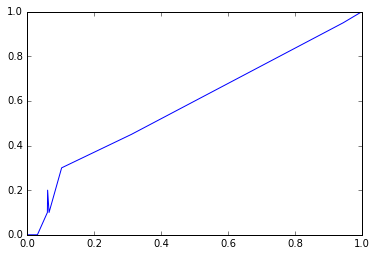

In [128]:
%matplotlib inline

import matplotlib.pylab as plt

x_roc = np.array([0] + [r[1][0] for r in result])
y_roc = np.array([0] + [r[1][1] for r in result])

_ = plt.plot(x_roc, y_roc)

In [129]:
def area_under_roc(x, y):
    x_delta = x[1:] - x[:-1]
    y_delta = y[1:] - y[:-1]
    rect_bases = 1 - x[1:]
    
    return sum(x_delta*y_delta)/2 + sum(y_delta*rect_bases)

In [130]:
area_under_roc(x_roc, y_roc)

0.58540780141843962

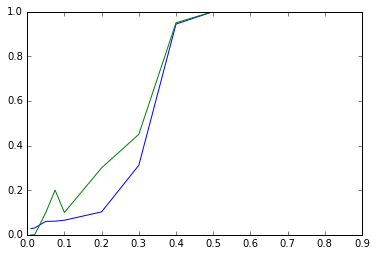

In [131]:
_ = plt.plot([r[0] for r in result], [r[1][0] for r in result], 'b')
_ = plt.plot([r[0] for r in result], [r[1][1] for r in result], 'g')

# nota: in blu gli easy falsamente dati come hard, in verde gli hard
# correttamente beccati come tali

In [139]:
metrics = lambda v: (np.min(v), np.mean(v), np.median(v), np.max(v))

In [153]:
easy_hard_distance = pd.DataFrame(map(metrics,
                [[k.compute(e, h) for h in hard_axiom_indices]
                           for e in easy_axiom_indices]),
                columns=('min', 'mean', 'median', 'max'))

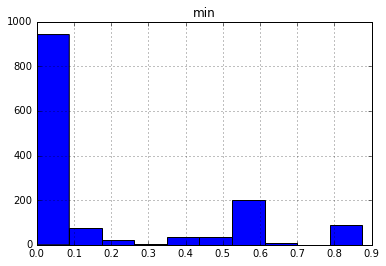

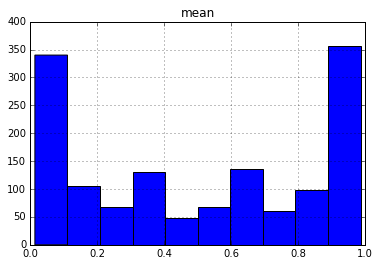

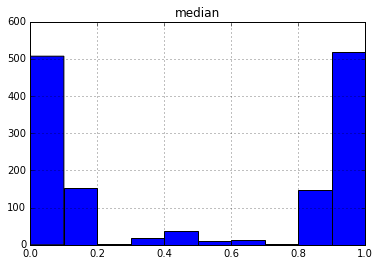

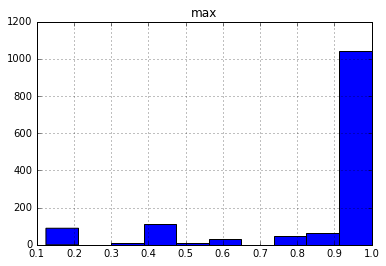

In [155]:
for s in easy_hard_distance:
    easy_hard_distance[s].hist()
    plt.title(s)
    plt.show()

In [156]:
hard_hard_distance = pd.DataFrame(map(metrics,
                    [[k.compute(h1, h2) for h1 in hard_axiom_indices]
                     for h2 in hard_axiom_indices if h2!=h1]),
                    columns=('min', 'mean', 'median', 'max'))

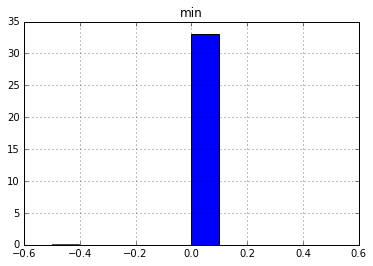

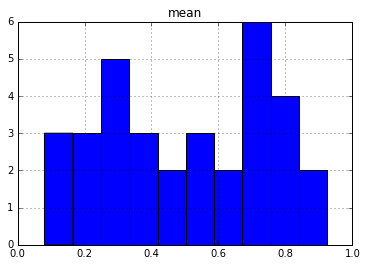

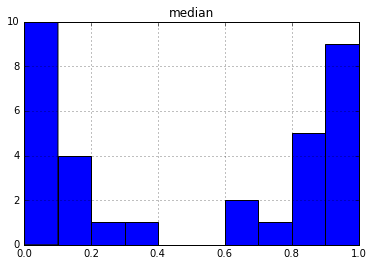

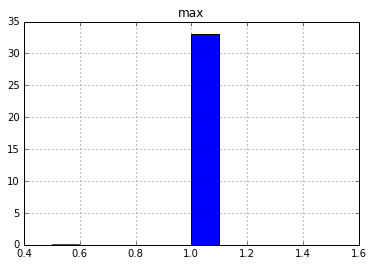

In [157]:
for s in hard_hard_distance:
    hard_hard_distance[s].hist()
    plt.title(s)
    plt.show()

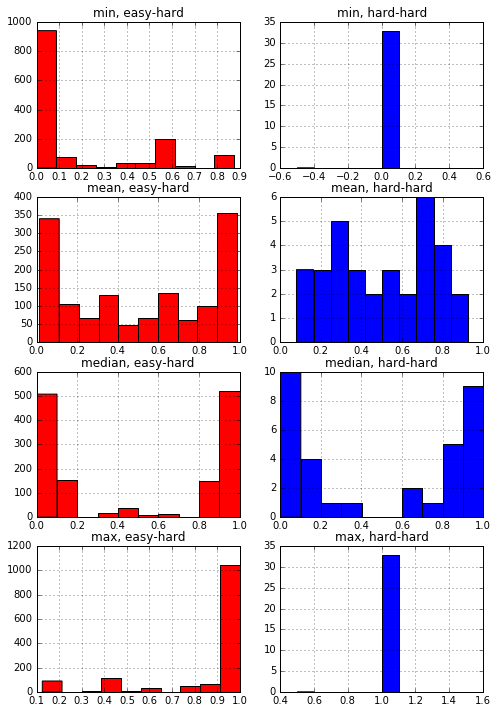

In [170]:
plt.figure(figsize=(8, 12))

for i, s in enumerate(easy_hard_distance):
    plt.subplot(4, 2, 2*i+1)
    easy_hard_distance[s].hist(color='r')
    plt.title('{}, easy-hard'.format(s))
    plt.xlim=((0,1))

for i, s in enumerate(hard_hard_distance):
    plt.subplot(4, 2, 2*(i+1))
    hard_hard_distance[s].hist()
    plt.title('{}, hard-hard'.format(s))
    plt.xlim=((0,1))

In [172]:
hard_axiom_indices

[112,
 113,
 170,
 171,
 202,
 203,
 398,
 399,
 426,
 427,
 548,
 549,
 806,
 807,
 836,
 837,
 886,
 887,
 890,
 891,
 972,
 973,
 976,
 977,
 980,
 981,
 1006,
 1007,
 1016,
 1017,
 1028,
 1029,
 1232,
 1233]